In [1]:
%load_ext autoreload
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns  # Seaborn enhances the aesthetics of matplotlib plots

import pandas as pd
import xarray as xr
import seaborn as sns
import warnings
import logging
# sns.set()

from tempest import casestudy
from tempest import grid
from tempest import storm_tracker
from tempest import joint_distrib
from tempest import handler
from tempest.plots.hist import simple_hist

In [ ]:
settings_path = 'settings/obs_winter_30d.yaml'
hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
gr = grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False)
st = storm_tracker.StormTracker(gr, label_var_id = "MCS_label", overwrite_storms = False, overwrite = False)
jd = joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_85_Prec",nbpd = 20,  nd=5, overwrite = True, dist_mask = False)

Data loaded from /scratchx/mcarenso/tempest/OBS_Winter_lowRes_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /scratchx/mcarenso/tempest/OBS_Winter_lowRes_Tropics/grid_attributes.pkl instead of computing


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


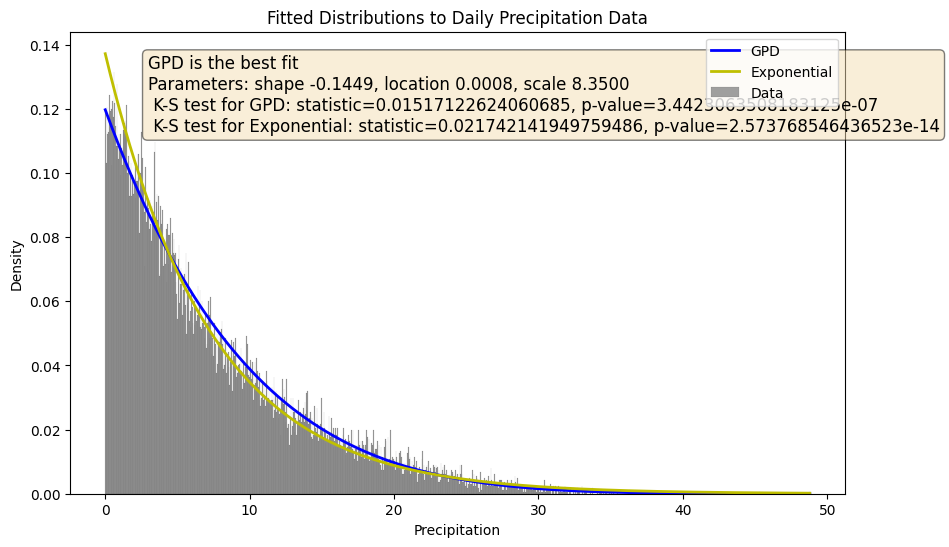

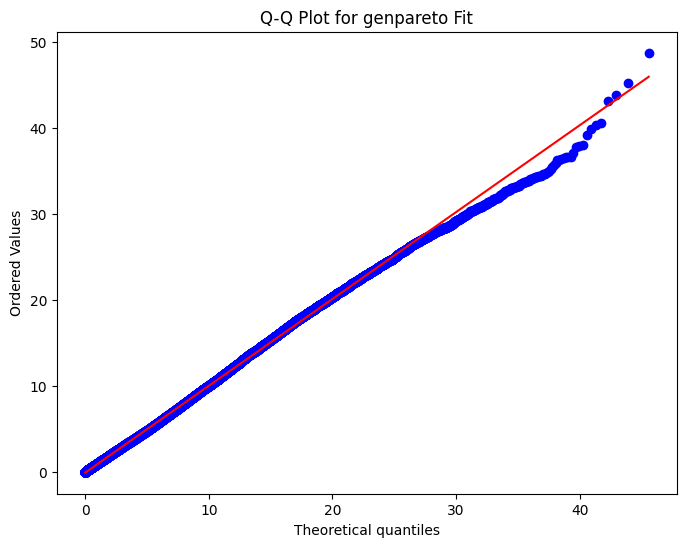

GPD is the best fit
Parameters: shape -0.1449, location 0.0008, scale 8.3500 
 K-S test for GPD: statistic=0.01517122624060685, p-value=3.4423063508183125e-07 
 K-S test for Exponential: statistic=0.021742141949759486, p-value=2.573768546436523e-14
Value at Risk (VaR) at 95.0%: 20.659581279754637
Expected Shortfall (TVaR/CVaR) at 95.0%: 24.919638276791026
Hill Estimator for the tail index (k=3381): 0.2401908113469621
GPD Parameters: Shape=-0.14491530938603392, Location=0.0007782934914850519, Scale=8.35002377156852
Expected Shortfall (ES) at 95%: 24.919638276791026



In [3]:
dist_name2, params2, data2 = jd.fit_sample(2, True, False) ## dist_name is either genpareto or expon

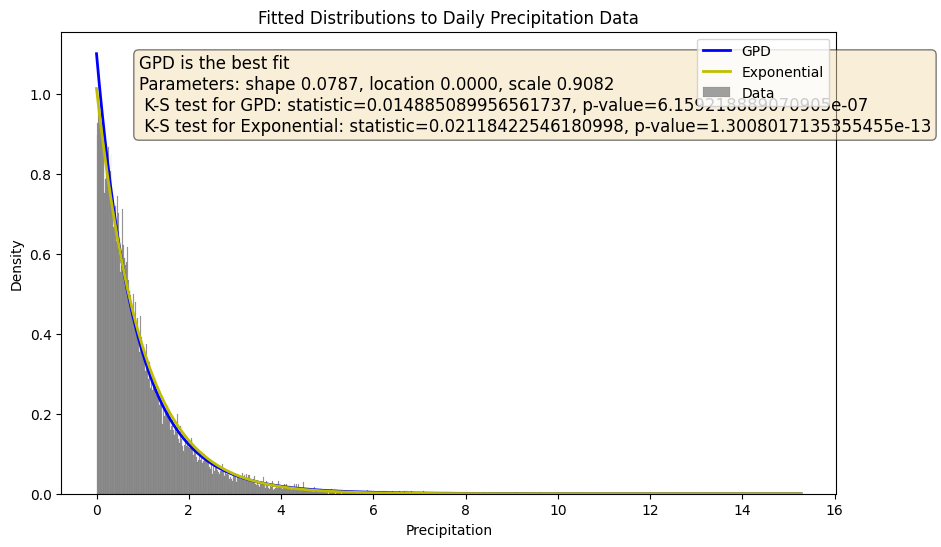

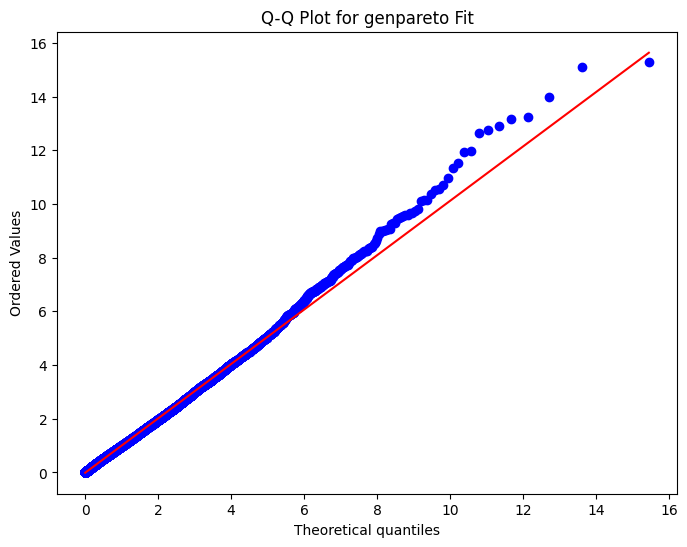

GPD is the best fit
Parameters: shape 0.0787, location 0.0000, scale 0.9082 
 K-S test for GPD: statistic=0.014885089956561737, p-value=6.159218889070905e-07 
 K-S test for Exponential: statistic=0.02118422546180998, p-value=1.3008017135355455e-13
Value at Risk (VaR) at 95.0%: 3.064275860786438
Expected Shortfall (TVaR/CVaR) at 95.0%: 4.401350715751129
Hill Estimator for the tail index (k=3381): 0.38519383767843596
GPD Parameters: Shape=0.07869170270761232, Location=6.1986110977254864e-06, Scale=0.90824478298809
Expected Shortfall (ES) at 95%: 4.401350715751129



In [4]:
dist_name1, params1, data1 = jd.fit_sample(1, True, False) ## dist_name is either genpareto or expon

In [5]:
from scipy.stats import norm, \
    beta, cauchy, expon, rayleigh, uniform, multivariate_t, t
from scipy.optimize import brentq

In [6]:
corr_coef = np.corrcoef(jd.sample1.reshape(-1), jd.sample2.reshape(-1))[0, 1]
corr_coef

0.7782535447452302

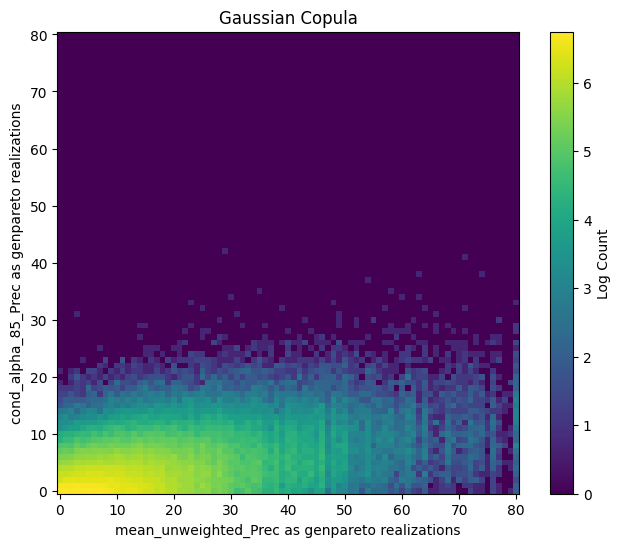

In [12]:
from scipy.stats import genpareto, expon, norm

r = corr_coef
P = np.asarray([
    [1, r],
    [r, 1]
])
d = P.shape[0]
n_samples = len(jd.sample1)

if dist_name1 == "genpareto" :
    dist1 = genpareto(*params1)
elif dist_name1 == "expon":
    dist1 = expon(*params1)
    
if dist_name2 == "genpareto" :
    dist2 = genpareto(*params2)
elif dist_name2 == "expon":
    dist2 = expon(*params2)
    
# Cholesky decomposition
A = np.linalg.cholesky(P)

# Generate standard normal samples
Z = np.random.normal(size=(n_samples, d))

# Generate Gaussian copula samples
U_Gauss = norm.cdf(np.matmul(Z, A))

# Transform the Gaussian copula samples to GPD and Exponential marginals
U1 = U_Gauss[:, 0]
U2 = U_Gauss[:, 1]

# Use PPF (inverse CDF) to transform to the desired distributions
x = dist1.ppf(U1)
y = dist2.ppf(U2)


# Create the 2D histogram
x_bins = jd.dist1.bins[np.argwhere(jd.dist1.ranks==90)[0][0]:]
y_bins = jd.dist2.bins[np.argwhere(jd.dist2.ranks==90)[0][0]:]
hist, x_edges, y_edges = np.histogram2d(x, y, bins=[x_bins, y_bins])

# Compute the log of the bin counts, avoiding log(0) by using np.log1p
log_hist = np.log1p(hist)

# Plot the 2D histogram with log scale
plt.figure(figsize=(8, 6))
plt.imshow(log_hist.T, origin='lower', cmap='viridis')
plt.colorbar(label='Log Count')
plt.title('Gaussian Copula')
plt.xlabel(f'{jd.var_id_1} as {dist_name1} realizations')
plt.ylabel(f'{jd.var_id_2} as {dist_name2} realizations')
plt.show()


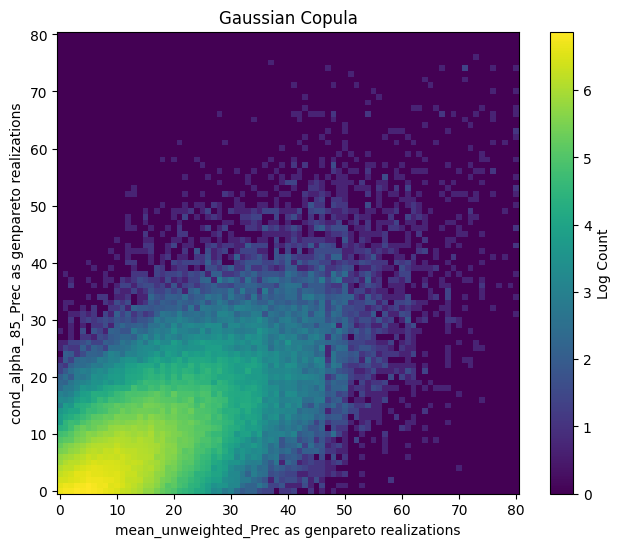

In [17]:
from scipy.stats import genpareto, expon, norm

r = corr_coef
mu = np.asarray([0, 0])
sigma = np.asarray([[1, r], [r, 1]])
nu = 20  # degrees of freedom for T dist. (I don't know this thing)
rv = multivariate_t(mu, sigma, df=nu)
n_samples = len(jd.sample1)
X = rv.rvs(size=n_samples)
U_StudentT = np.zeros_like(X)
t_dist = t(nu)
U_StudentT[:,0] = t_dist.cdf(X[:,0])
U_StudentT[:,1] = t_dist.cdf(X[:,1])

if dist_name1 == "genpareto" :
    dist1 = genpareto(*params1)
elif dist_name1 == "expon":
    dist1 = expon(*params1)
    
if dist_name2 == "genpareto" :
    dist2 = genpareto(*params2)
elif dist_name2 == "expon":
    dist2 = expon(*params2)
    
H1 = np.empty_like(U_StudentT)
# Use PPF (inverse CDF) to transform to the desired distributions
H1[:,0] = dist1.ppf(U_StudentT[:,0]); H1[:,1] = dist2.ppf(U_StudentT[:,1]); 

x = H1[:,0]
y = H1[:,1]


# Create the 2D histogram
x_bins = jd.dist1.bins[np.argwhere(jd.dist1.ranks==90)[0][0]:]
y_bins = jd.dist2.bins[np.argwhere(jd.dist2.ranks==90)[0][0]:]
hist, x_edges, y_edges = np.histogram2d(x, y, bins=[x_bins, y_bins])

# Compute the log of the bin counts, avoiding log(0) by using np.log1p
log_hist = np.log1p(hist)

# Plot the 2D histogram with log scale
plt.figure(figsize=(8, 6))
plt.imshow(log_hist.T, origin='lower', cmap='viridis')
plt.colorbar(label='Log Count')
plt.title('Gaussian Copula')
plt.xlabel(f'{jd.var_id_1} as {dist_name1} realizations')
plt.ylabel(f'{jd.var_id_2} as {dist_name2} realizations')
plt.show()

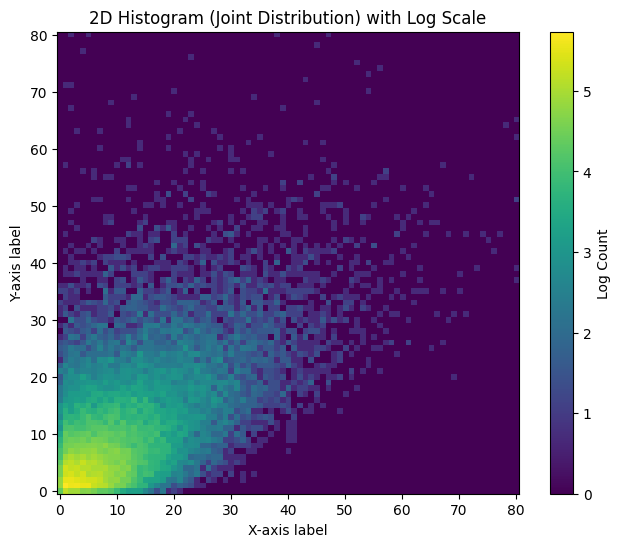

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data, replace with your actual data
x = data1
y = data2

# Create the 2D histogram
treshold1 = jd.dist1.percentiles[jd.dist1.ranks==90]
treshold2 = jd.dist2.percentiles[jd.dist2.ranks==90]

x_bins = jd.dist1.bins[np.argwhere(jd.dist1.ranks==90)[0][0]:] - treshold1
y_bins = jd.dist2.bins[np.argwhere(jd.dist2.ranks==90)[0][0]:] - treshold2


hist, x_edges, y_edges = np.histogram2d(x, y, bins=[x_bins, y_bins])

# Compute the log of the bin counts, avoiding log(0) by using np.log1p
log_hist = np.log1p(hist)

# Plot the 2D histogram with log scale
plt.figure(figsize=(8, 6))
plt.imshow(log_hist.T, origin='lower', cmap='viridis')
plt.colorbar(label='Log Count')
plt.title('2D Histogram (Joint Distribution) with Log Scale')
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.show()

In [16]:
x_bins

array([ 0.43962166,  0.50370021,  0.56998867,  0.63728152,  0.71092898,
        0.78625711,  0.86809925,  0.9506045 ,  1.03585298,  1.12285233,
        1.21108801,  1.3065242 ,  1.40324661,  1.50118416,  1.6030552 ,
        1.7098412 ,  1.81670132,  1.93497402,  2.04766646,  2.16585152,
        2.2759957 ,  2.39871388,  2.51218032,  2.62848191,  2.75841374,
        2.8769432 ,  3.01292514,  3.1583242 ,  3.28605262,  3.43973169,
        3.5804649 ,  3.71313979,  3.83397335,  3.96671251,  4.10851946,
        4.263639  ,  4.43253687,  4.56321549,  4.68813031,  4.84112245,
        4.96421856,  5.13192005,  5.30925238,  5.46039348,  5.6418719 ,
        5.83434618,  6.02550909,  6.30008658,  6.42901294,  6.66368994,
        6.8879664 ,  7.15388112,  7.28849587,  7.44439657,  7.59366757,
        7.8466206 ,  8.01599279,  8.18358086,  8.38837553,  8.55746231,
        8.7043423 ,  8.88388214,  9.21393941,  9.49495721,  9.62713036,
        9.91936784, 10.0181903 , 10.13215219, 10.25067281, 10.60

In [22]:
jd.sample1[np.argwhere(jd.sample2>50)]

array([[0.79901242],
       [0.26638335],
       [0.2334729 ],
       [0.59879994],
       [4.81186008],
       [6.30805159]])

In [26]:
jd.dist1.percentiles[jd.dist1.ranks==90]

array([0.4715271])